# Manipulaçao inicial dos dados
Precisei jogar os dados Json em um banco de dados, tratá-los removendo informações desnecessárias para minha análise, e então puxá-los novamente via código. Salvei em csv para que a consulta fosse mais àgil.

In [ ]:
# Bibliotecas utilizadas no notebook, tenha certeza de que estão instaladas

import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
from scipy import stats

In [ ]:
# Banco de dados GCP

# Dados do banco de dados (substitua com suas credenciais)
db_user = 'postgres'
db_password = '1234'
db_host = '104.154.71.21'  # Pode ser o endereço IP do servidor ou o hostname
db_port = '5432'  # Porta padrão do PostgreSQL
db_name = 'postgres'

# String de conexão com SQLAlchemy
connection_string = f'postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}'

# Criar engine de conexão
engine = create_engine(connection_string)

In [ ]:
# Banco de dados PostgreSQL local

# Dados do banco de dados (substitua com suas credenciais)
db_user = 'postgres'
db_password = '1234'
db_host = 'localhost'  # Pode ser o endereço IP do servidor ou o hostname
db_port = '5432'  # Porta padrão do PostgreSQL
db_name = 'iFood'

# String de conexão com SQLAlchemy
connection_string = f'postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}'

# Criar engine de conexão
engine = create_engine(connection_string)


In [ ]:
# Puxando tabela orders_ab_test do banco de dados

query = """select * from public.orders_ab_test"""
df = pd.read_sql(query, engine)

In [ ]:
df.to_csv('orders_ab_test.csv', index=False)


# Pode começar a rodar aqui!
desde que os arquivos CSV estejam no mesmo diretório do notebook.

In [5]:
# Bibliotecas utilizadas no notebook, tenha certeza de que estão instaladas

import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
from scipy import stats

In [6]:
df = pd.read_csv('orders_ab_test.csv')

In [7]:
usuarios_unicos_controle = df[df['is_target'] == 'control']['customer_id'].nunique()
usuarios_unicos_target = df[df['is_target'] == 'target']['customer_id'].nunique()

print(f"Usuários únicos no grupo controle: {usuarios_unicos_controle}")
print(f"Usuários únicos no grupo target: {usuarios_unicos_target}")

Usuários únicos no grupo controle: 360542
Usuários únicos no grupo target: 445924


In [8]:
# Selecionar 360542 usuários únicos de cada grupo (control e target)
usuarios_unicos_control = df[df['is_target'] == 'control']['customer_id'].drop_duplicates().sample(n=360542, random_state=42)
usuarios_unicos_target = df[df['is_target'] == 'target']['customer_id'].drop_duplicates().sample(n=360542, random_state=42)

# Filtrar o dataframe original para manter apenas esses usuários
df_filtrado = df[df['customer_id'].isin(usuarios_unicos_control) | df['customer_id'].isin(usuarios_unicos_target)]

# Contar a quantidade de usuários únicos nos grupos control e target do df_filtrado
usuarios_unicos_control_filtrado = df_filtrado[df_filtrado['is_target'] == 'control']['customer_id'].nunique()
usuarios_unicos_target_filtrado = df_filtrado[df_filtrado['is_target'] == 'target']['customer_id'].nunique()

# Contar a quantidade total de linhas do df_filtrado
total_linhas_filtrado_target = len(df_filtrado[df_filtrado['is_target'].isin(['target'])])
total_linhas_filtrado_control = len(df_filtrado[df_filtrado['is_target'].isin(['control'])])
total_linhas_filtrado = len(df_filtrado)

print(f"Total de usuários únicos no grupo control: {usuarios_unicos_control_filtrado}")
print(f"Total de usuários únicos no grupo target: {usuarios_unicos_target_filtrado}")
print(f"Total de linhas em total_linhas_filtrado_control: {total_linhas_filtrado_control}")
print(f"Total de linhas em total_linhas_filtrado_target: {total_linhas_filtrado_target}")
print(f"Total de linhas em df_filtrado: {total_linhas_filtrado}")

Total de usuários únicos no grupo control: 360542
Total de usuários únicos no grupo target: 360542
Total de linhas em total_linhas_filtrado_control: 1525576
Total de linhas em total_linhas_filtrado_target: 1727049
Total de linhas em df_filtrado: 3252625


In [9]:
df = df_filtrado
df.columns

Index(['customer_id', 'merchant_id', 'order_created_at', 'order_total_amount',
       'is_target'],
      dtype='object')

In [10]:
# Selecionar 1525576 linhas aleatórias do grupo 'target' para igualar o tamanho do grupo 'controle'
controle = df[df['is_target'] == 'control']
target = df[df['is_target'] == 'target']

print(f"controle: {len(controle)} linhas")
print(f"target: {len(target)} linhas")

controle: 1525576 linhas
target: 1727049 linhas


# Questão 1 - A:
Defina os indicadores relevantes para mensurar o sucesso da campanha e analise se ela teve impacto significativo dentro do período avaliado.

## Indicador 1: Qtd média de pedidos por usuário único por grupo

In [9]:
# Contar as ocorrências de 'customer_id' para controle e target
count_customer_id_controle = controle['customer_id'].value_counts()
count_customer_id_target = target['customer_id'].value_counts()

# Calcular a média das ocorrências
media_ocorrencias_controle = count_customer_id_controle.mean()
media_ocorrencias_target = count_customer_id_target.mean()

# Exibir os resultados
print(f"Média de pedidos por usuário grupo controle: {media_ocorrencias_controle:.2f}")
print(f"Média de pedidos por usuário grupo target: {media_ocorrencias_target:.2f}")

Média de pedidos por usuário grupo controle: 4.23
Média de pedidos por usuário grupo target: 4.79


## Indicador 2: Soma do valor total dos pedidos por usuário

In [10]:
soma_controle = controle['order_total_amount'].sum()
soma_target = target['order_total_amount'].sum()

print(f"Soma do total dos pedidos grupo controle: R$ {soma_controle:,.2f}".replace(",", "X").replace(".", ",").replace("X", "."))
print(f"Soma do total dos pedidos grupo target: R$ {soma_target:,.2f}".replace(",", "X").replace(".", ",").replace("X", "."))
print(f"Diff: target - controle = R$ {(soma_target - soma_controle):,.2f}".replace(",", "X").replace(".", ",").replace("X", "."))

Soma do total dos pedidos grupo controle: R$ 73.071.872,88
Soma do total dos pedidos grupo target: R$ 82.444.051,85
Diff: target - controle = R$ 9.372.178,97


## Indicador 3: Valor médio gasto por usuário

In [109]:
# Calcular o valor médio gasto por customer_id para cada grupo
media_gasto_controle = controle.groupby('customer_id')['order_total_amount'].mean().mean()
media_gasto_target = target.groupby('customer_id')['order_total_amount'].mean().mean()

print(f"Valor médio gasto por usuário grupo controle: {media_gasto_controle:.2f}")
print(f"Valor médio gasto por usuário grupo target: {media_gasto_target:.2f}")

Valor médio gasto por usuário grupo controle: 48.01
Valor médio gasto por usuário grupo target: 47.87


## Teste de Hipóteses
Hipótese nula (H0): Não houve diferença significativa entre o grupo de controle e o grupo de teste.

Hipótese alternativa (H1): Houve uma diferença significativa entre o grupo de controle e o grupo de teste (ou seja, a campanha teve impacto).

### Histogramas

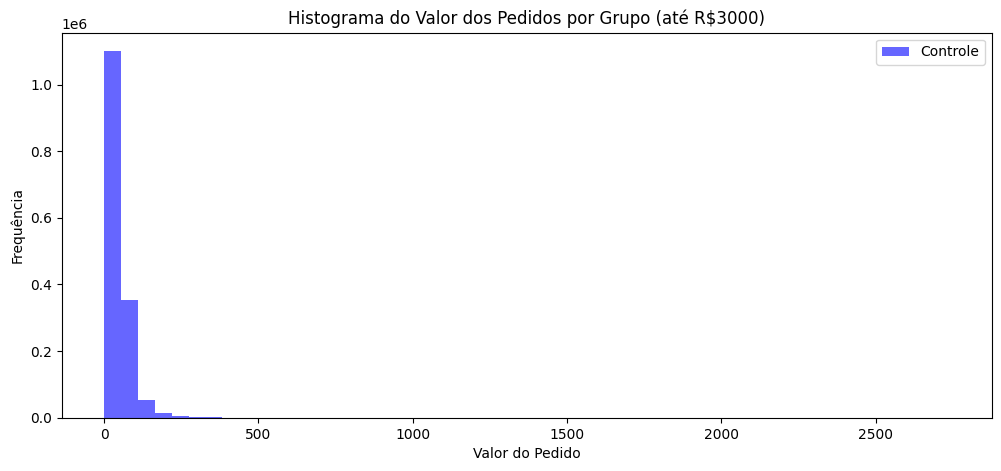

In [ ]:
# Histograma do valor dos pedidos por grupo controle (até R$3000)

plt.figure(figsize=(12, 5))

plt.hist(controle['order_total_amount'][controle['order_total_amount'] <= 3000], bins=50, alpha=0.6, label='Controle', color='blue')

plt.xlabel('Valor do Pedido')
plt.ylabel('Frequência')
plt.title('Histograma do Valor dos Pedidos por Grupo (até R$3000)')
plt.legend()
plt.show()

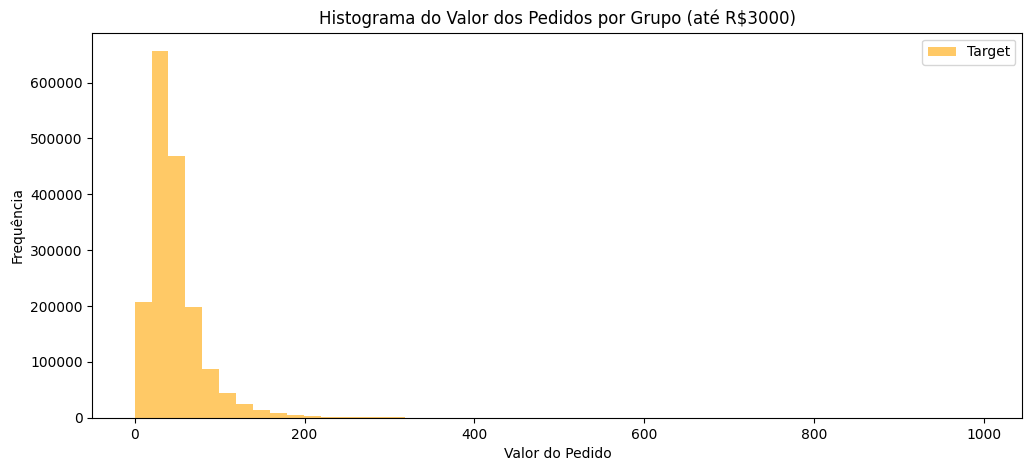

In [43]:
# Histograma do valor dos pedidos por grupo target (até R$3000)

plt.figure(figsize=(12, 5))

# plt.hist(controle['order_total_amount'][controle['order_total_amount'] <= 3000], bins=50, alpha=0.6, label='Controle', color='blue')
plt.hist(target['order_total_amount'][target['order_total_amount'] <= 1000], bins=50, alpha=0.6, label='Target', color='orange')

plt.xlabel('Valor do Pedido')
plt.ylabel('Frequência')
plt.title('Histograma do Valor dos Pedidos por Grupo (até R$3000)')
plt.legend()
plt.show()

#### Observações

Ambos os gráficos apresentam uma distribuição assimétrica à direita, o que significa que a maior parte dos pedidos está concentrada em valores baixos, mas há uma pequena quantidade de pedidos com valores significativamente mais altos.

### Métricas de cada grupo

In [46]:
# Estatísticas descritivas do valor total dos pedidos para cada grupo, formatadas
def describe_format(series):
    desc = series.describe()
    return (
        f"count: {int(desc['count']):,}\n"
        f"mean: R$ {desc['mean']:,.2f}\n"
        f"std: R$ {desc['std']:,.2f}\n"
        f"min: R$ {desc['min']:,.2f}\n"
        f"25%: R$ {desc['25%']:,.2f}\n"
        f"50%: R$ {desc['50%']:,.2f}\n"
        f"75%: R$ {desc['75%']:,.2f}\n"
        f"max: R$ {desc['max']:,.2f}"
    ).replace(",", "X").replace(".", ",").replace("X", ".")

print("Grupo Controle:")
print(describe_format(controle['order_total_amount']))
print("\nGrupo Target:")
print(describe_format(target['order_total_amount']))

Grupo Controle:
count: 1.525.576
mean: R$ 47,90
std: R$ 165,05
min: R$ 0,00
25%: R$ 26,99
50%: R$ 39,90
75%: R$ 57,30
max: R$ 138.750,90

Grupo Target:
count: 1.727.049
mean: R$ 47,74
std: R$ 46,97
min: R$ 0,00
25%: R$ 26,90
50%: R$ 39,80
75%: R$ 57,40
max: R$ 35.988,00


#### **Observações**

Médias próximas, mediana distante da media, assimetria positiva, distribuição com cauda longa.<br>
75% dos usuários gastam até 60 reais, em ambos os grupos.

fazer a distribuição normal dos dados (histograma)
dados nao são normais, logo : fazer testes não paramétricos
dados independentes

In [32]:
# Importando a biblioteca necessária
from scipy.stats import shapiro

# Exemplo de dados
dados = controle['order_total_amount']

# Realizando o Teste de Shapiro-Wilk
stat, p_value = shapiro(dados)

# Saída dos resultados
print(f'Estatística de teste: {stat:.4f}')
print(f'Valor p: {p_value:.4f}')

# Interpretação
alpha = 0.05
if p_value > alpha:
 print("Não há evidências suficientes para rejeitar a hipótese de normalidade (os dados parecem normalmente distribuídos).")
else:
 print("Há evidência suficiente para rejeitar a hipótese de normalidade (os dados não parecem normalmente distribuídos).")

 # vou ter que usar um teste não paramétrico, o teste de Mann-Whitney

Estatística de teste: 0.0344
Valor p: 0.0000
Há evidência suficiente para rejeitar a hipótese de normalidade (os dados não parecem normalmente distribuídos).


In [26]:
# Estatísticas descritivas do valor total dos pedidos para cada grupo, formatadas
def describe_format(series):
    desc = series.describe()
    return (
        f"count: {int(desc['count']):,}\n"
        f"mean: R$ {desc['mean']:,.2f}\n"
        f"std: R$ {desc['std']:,.2f}\n"
        f"min: R$ {desc['min']:,.2f}\n"
        f"25%: R$ {desc['25%']:,.2f}\n"
        f"50%: R$ {desc['50%']:,.2f}\n"
        f"75%: R$ {desc['75%']:,.2f}\n"
        f"max: R$ {desc['max']:,.2f}"
    ).replace(",", "X").replace(".", ",").replace("X", ".")

print("Grupo Controle:")
print(describe_format(controle['order_total_amount']))
print("\nGrupo Target:")
print(describe_format(target['order_total_amount']))

Grupo Controle:
count: 1.525.576
mean: R$ 47,90
std: R$ 165,05
min: R$ 0,00
25%: R$ 26,99
50%: R$ 39,90
75%: R$ 57,30
max: R$ 138.750,90

Grupo Target:
count: 1.727.049
mean: R$ 47,74
std: R$ 46,97
min: R$ 0,00
25%: R$ 26,90
50%: R$ 39,80
75%: R$ 57,40
max: R$ 35.988,00


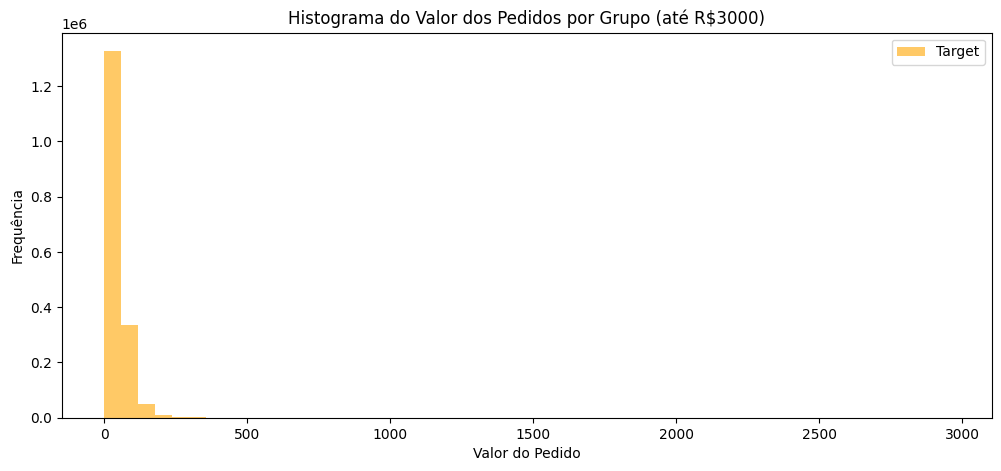

In [14]:
plt.figure(figsize=(12, 5))

# plt.hist(controle['order_total_amount'][controle['order_total_amount'] <= 3000], bins=50, alpha=0.6, label='Controle', color='blue')
plt.hist(target['order_total_amount'][target['order_total_amount'] <= 3000], bins=50, alpha=0.6, label='Target', color='orange')

plt.xlabel('Valor do Pedido')
plt.ylabel('Frequência')
plt.title('Histograma do Valor dos Pedidos por Grupo (até R$3000)')
plt.legend()
plt.show()

### Validando normalidade dos dados - Teste de Shapiro-Wilk

É importante entender a distribuição normal dos dados para definir o teste mais correto a se aplicar.

In [33]:
# Importando a biblioteca necessária
from scipy.stats import shapiro

# Exemplo de dados
dados = controle['order_total_amount']

# Realizando o Teste de Shapiro-Wilk
stat, p_value = shapiro(dados)

# Saída dos resultados
print(f'Estatística de teste: {stat:.4f}')
print(f'Valor p: {p_value:.4f}')

# Interpretação
alpha = 0.05
if p_value > alpha:
 print("Não há evidências suficientes para rejeitar a hipótese de normalidade (os dados parecem normalmente distribuídos).")
else:
 print("Há evidência suficiente para rejeitar a hipótese de normalidade (os dados não parecem normalmente distribuídos).")

 # vou ter que usar um teste não paramétrico, o teste de Mann-Whitney

Estatística de teste: 0.0344
Valor p: 0.0000
Há evidência suficiente para rejeitar a hipótese de normalidade (os dados não parecem normalmente distribuídos).


### Realizando o teste de Mann-Whitney

Como se tratam de dados fora da distribuição normal, utilizaremos o teste de Mann-Whitney

In [37]:
# Importando a biblioteca necessária
from scipy.stats import mannwhitneyu

# Suponha que você tenha seus dados em duas listas ou arrays
# Exemplo fictício (substitua pelos seus dados reais)
grupo_A = controle['order_total_amount']
grupo_B = target['order_total_amount']

# Realizando o teste de Mann-Whitney U
stat, p_value = mannwhitneyu(grupo_A, grupo_B, alternative='two-sided')

# Saída dos resultados
print(f'Estatística U: {stat}')
print(f'Valor p: {p_value:.6f}')

# Interpretação
alpha = 0.05
if p_value < alpha:
 print("Há diferença estatisticamente significativa entre os grupos A e B.")
 print("A hipótese nula do teste (que não há diferença entre os grupos) foi rejeitada. Logo, é razoável concluir que a campanha teve algum efeito que gerou uma diferença nos comportamentos observados entre os dois grupos.")
else:
 print("Não há diferença estatisticamente significativa entre os grupos A e B.")
 

Estatística U: 1319038833769.5
Valor p: 0.048596
Há diferença estatisticamente significativa entre os grupos A e B.
A hipótese nula do teste (que não há diferença entre os grupos) foi rejeitada. Logo, é razoável concluir que a campanha teve algum efeito que gerou uma diferença nos comportamentos observados entre os dois grupos.


In [ ]:
# Análise estatística (teste t)
## Comparar o valor médio dos pedidos entre os dois grupos.
t_stat, p_value = stats.ttest_ind(target['order_total_amount'], controle['order_total_amount'])

In [11]:
print(f"Estatísticas do teste t: \nt-stat = {t_stat:.4f}, p-value = {p_value:.4f}")

# Concluir se a campanha teve impacto significativo
## Valor positivo (t > 0): Indica que a média do grupo de teste é maior que a do grupo de controle.
## Valor negativo (t < 0): Indica que a média do grupo de controle é maior que a do grupo de teste.
## Valor t = 0: Significa que não há diferença entre as médias dos dois grupos.

if p_value < 0.05:
    print("A campanha teve um impacto significativo.")
else:
    print("A campanha não teve impacto significativo.")

Estatísticas do teste t: 
t-stat = -1.2265, p-value = 0.2200
A campanha não teve impacto significativo.


### Interpretação dos dados

Média de pedidos por usuário grupo controle: 4,23<br>
Média de pedidos por usuário grupo target: 4,79

Soma do total dos pedidos grupo controle: 73.071.872,88<br>
Soma do total dos pedidos grupo target: 82.444.051,85<br>
Diff: target - controle = 9.372.178,97

Valor médio gasto por usuário grupo controle: 48,01<br>
Valor médio gasto por usuário grupo target: 47,87


___

Considerando os dados acima, vemos que o grupo target fez em média mais pedidos, a um valor médio por pedido menor que o grupo controle que não recebeu cupons, resultando em um somatório 9.372 milhões de reais gastos a mais que o grupo controle. Isso indica que por receber mais incentivo de compras os usuários acabaram consumindo mais dentro do app, porém não gastaram mais do que pretendiam por causa do cupom.

# Questão 1 - B:

Faça uma análise de viabilidade financeira dessa iniciativa como alavanca de crescimento, adotando as premissas que julgar necessárias (explicite as premissas adotadas).

### Premissas:
Valor médio do cupom: 10%

O cupom de 10% foi o único fator de diferenciação entre o grupo controle e o grupo target.

O impacto no grupo target pode ser medido pela diferença de vendas em relação ao grupo controle.

Nenhum outro fator externo (como sazonalidade, outras promoções, etc.) impactou diretamente os resultados.

O valor total de pedidos foi utilizado para medir o sucesso da campanha.

O custo do cupom foi considerado diretamente no cálculo do investimento da campanha.

In [149]:
# Calcular o valor total de pedidos do grupo controle e do grupo target
total_pedidos_controle = controle['order_total_amount'].sum()
total_pedidos_target = target['order_total_amount'].sum()

# Valor total de pedidos do grupo target em relação ao grupo controle
diferenca_total_pedidos = total_pedidos_target - total_pedidos_controle

# Calcular o valor total de pedidos do grupo target desconsiderando o cupom
lucro_target_sem_cupom = target['order_total_amount'].sum() / 0.9  # Considerando o cupom de 10%

# Entender quanto o iFood investiu em cupons pra oferecer os 10% de desconto
investimento_cupom = lucro_target_sem_cupom - total_pedidos_target

# Calcular o lucro real considerando o investimento em cupons
lucro_real = diferenca_total_pedidos - investimento_cupom

print(f"total_pedidos_controle: {total_pedidos_controle:,.2f}")
print(f"total_pedidos_target: {total_pedidos_target:,.2f}")
print(f"lucro_target_sem_cupom: {lucro_target_sem_cupom:,.2f}")
print(f"diferenca_total_pedidos: {diferenca_total_pedidos:,.2f}")
print(f"investimento_cupom: {investimento_cupom:,.2f}")
print(f"lucro_real: {lucro_real:,.2f}")


total_pedidos_controle: 73,071,872.88
total_pedidos_target: 82,444,051.85
lucro_target_sem_cupom: 91,604,502.06
diferenca_total_pedidos: 9,372,178.97
investimento_cupom: 9,160,450.21
lucro_real: 211,728.76


### Viabilidade Financeira

1. O iFood gastou R$ 9,16 milhões com os cupons para gerar mais vendas no grupo target. Esse é o custo da campanha.
2. O valor de vendas gerado no grupo target foi R$ 9,37 milhões a mais em comparação com o grupo controle. Isso mostra que a campanha teve impacto positivo nas vendas.
3. Mesmo considerando o custo do cupom, o lucro da campanha foi de R$ 211.728,76.
4. ROI (return of investiment): 2,26%

Embora o lucro real da campanha seja relativamente pequeno (R$ 211 mil), a campanha de cupons foi financeiramente viável como alavanca de crescimento, pois gerou R$ 9,37 milhões adicionais em vendas. O objetivo dessa campanha era principalmente retenção de usuários, que pode ser considerado como atingido, pois, os clientes mais uma vez optaram por fazer compras no iFood, alimentando um hábito e o sentimento de confiança contribuindo também para a lealdade do usuário.

# Questão 1 - C:

Recomende oportunidades de melhoria nessa ação e desenhe uma nova proposta de teste A/B para validar essas hipóteses.

## Oportunidades de melhoria 

1. **Hipótese:** Implementação de descontos progressivos com base no valor da compra aumenta a retenção e impacto financeiro.

    **Objetivo:** Avaliar se as faixas de desconto promovem maior engajamento do usuário, aumentando valor gasto e média de pedidos por usuário, promovendo retenção.

    ### **Teste A/B**

    **Grupo A (Controle):** Cupom de 10% para todos os usuários.

    **Grupo B (Teste):**  
    Desconto progressivo:  
    - 5% para compras até R$ 50  
    - 10% para compras entre R$ 50 e R$ 100  
    - 15% para compras acima de R$ 100

    **Métricas a serem avaliadas para cada grupo:**
    - Valor médio do pedido
    - Quantidade média de pedidos por usuário
    - Gasto total por grupo

2. **Hipótese:** Colocar um prazo para uso dos cupons pode gerar um sentimento de urgência, levando os usuários a não esperarem muito tempo para comprar novamente, aumentando os indicadores.


    **Objetivo:** Dessa forma podemos avaliar se a validade do cupom aumenta engajamento, conversão e qual período de validade gera maior taxa de uso do cupom.

    ### **Teste A/B**

    **Grupo A (Controle):** Cupom de 10% sem validade.

    **Grupo B (Teste):** Cupom de 10% válido por 3 dias para todos os usuários.

    **Grupo C (Teste):** Cupom de 10% válido por 7 dias para todos os usuários.

    **Métricas a serem avaliadas:**
    - Valor médio do pedido
    - Quantidade média de pedidos por usuário
    - Gasto total por grupo


3. **Hipótese:** Cupons mais agressivos para clientes inativos aumenta engajamento e retenção.

    **Objetivo:** Avaliar qual faixa de desconto retém mais os usuários inativos.

    ### **Teste A/B**

    **Grupo A (Controle):** 1 cupom de 5% para usuários sem compras nos últimos 30 dias.

    **Grupo B (Teste):** 1 cupom de 10% para usuários sem compras nos últimos 30 dias.

    **Grupo C (Teste):** 1 cupom de 15% para usuários sem compras nos últimos 30 dias.

    **Métricas a serem avaliadas:**
    - Quantidade média de pedidos por usuário
    - Gasto total por grupo

4. **Hipótese:** Oferecer um cupom que pode ser usado várias vezes ao longo de 1 mês, ao invés de apenas um cupom único, aumenta o engajamento e o impacto financeiro, incentivando os usuários a realizarem mais compras e aumentando a retenção.

    **Objetivo:** Avaliar se a quantidade de pedidos por usuário aumenta ou diminui ao longo do tempo após a oferta, ou seja, nos permite avaliar retenção.

    ### **Teste A/B**

    **Grupo A (Controle):** Cupom de 10% de uso único para todos os usuários.

    **Grupo B (Teste):** Cupom de 10% que pode ser usado 3x ao longo de 30 dias.

    **Métricas a serem avaliadas para cada grupo:**
    - Valor médio do pedido
    - Quantidade média de pedidos por usuário
    - Gasto total por grupo
